# Anomalous detection system
* Used zeek to store around 2 weeks work of network data
* Data held around 600,000 packets from conn.log
* Cleaned the data
* One hot encoded non numerical data
* Constant kernal failures, had to reduce features ~55
* Simple tensorflow autoencoder
* 5 epochs
* PCA to visualize data

## Import Data
* Defined column names
* Loaded data into zeek_data

In [49]:
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import pandas as pd
import ipaddress
import hashlib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
import numpy as np
import joblib
from sklearn.ensemble import IsolationForest
pd.set_option('display.float_format', '{:.6f}'.format)
pd.set_option('future.no_silent_downcasting', True)
column_names = ['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'ip_proto']
zeek_data = pd.read_csv('./data.tsv', delimiter='\t', comment='#', names=column_names, dtype={'ts': 'float64'})
zeek_data



,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto
0,1740196546.358164,Covuo43LyFTNEu1Cp7,10.0.0.5,65430,99.181.107.78,443,tcp,-,0.176656,0,...,T,F,0,^dAtt,34,1876,169,237196,-,6
1,1740196546.358163,CGgOtJ35xc6GxibRug,10.0.0.5,65289,140.82.112.26,443,tcp,-,0.089289,24,...,T,F,0,^dADFaRfR,6,300,5,325,-,6
2,1740196568.851763,CX6Ki51nhyiL2A6494,10.0.0.5,65430,99.181.107.78,443,tcp,-,0.213978,1544,...,T,F,0,^dAttDa,29,3088,120,161605,-,6
3,1740196660.816343,CTSvKvuTLQBocHrOj,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,52768,2001:558:feed::1,53,udp,dns,0.019330,33,...,F,F,0,Dd,1,81,1,131,-,17
4,1740196660.816483,CtmXoQ1bMnUBBi68Pa,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,55558,2001:558:feed::1,53,udp,dns,0.017523,33,...,F,F,0,Dd,1,81,1,109,-,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589525,1741251435.893677,Cl9V7o3d5gUzwxmAmg,2601:647:cf01:5340:fa79:aff:fed6:65fb,1,2601:647:cf01:5340:210d:b639:9608:b036,0,icmp,-,156.840116,8290,...,F,F,0,-,97,12946,0,0,-,58
589526,1741250746.176140,CHc7xm1HIc1M2STFq7,fe80::833:d877:dbce:6f45,135,fe80::fa79:aff:fed6:65fb,136,icmp,-,838.535921,840,...,T,T,0,-,35,2520,35,2240,-,58
589527,1741250726.384061,C9j7yS2Mqpn8AqAIVc,fe80::833:d877:dbce:6f45,136,fe80::fa79:aff:fed6:65fb,135,icmp,-,871.438452,576,...,T,T,0,-,36,2304,16,1152,-,58
589528,1741250718.768333,ChOLqy4F73Wl6qIVsj,73.92.54.210,3,10.0.0.5,1,icmp,-,892.440025,122608,...,F,T,0,-,1703,170292,0,0,-,1


## Data Cleaning
* Dropped columns with missing values
* Filled rows with NaN to 0

In [50]:
print(zeek_data['ts'])# Drop rows with missing values
zeek_data = zeek_data.dropna()

zeek_data = zeek_data.dropna(axis=1, how='all')  # Drop columns with all NaN values
zeek_data['ts'] = pd.to_datetime(zeek_data['ts'], unit='s', utc=True).dt.tz_convert('US/Pacific')

zeek_data

zeek_data.columns = zeek_data.columns.str.strip()  # Remove any leading/trailing spaces
zeek_data.columns = zeek_data.columns.str.lower()  # Convert all column names to lowercase
zeek_data

0        1740196546.358164
1        1740196546.358163
2        1740196568.851763
3        1740196660.816343
4        1740196660.816483
                ...       
589525   1741251435.893677
589526   1741250746.176140
589527   1741250726.384061
589528   1741250718.768333
589529   1741250715.891635
Name: ts, Length: 589530, dtype: float64


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto
0,2025-02-21 19:55:46.358164072-08:00,Covuo43LyFTNEu1Cp7,10.0.0.5,65430,99.181.107.78,443,tcp,-,0.176656,0,...,T,F,0,^dAtt,34,1876,169,237196,-,6
1,2025-02-21 19:55:46.358163118-08:00,CGgOtJ35xc6GxibRug,10.0.0.5,65289,140.82.112.26,443,tcp,-,0.089289,24,...,T,F,0,^dADFaRfR,6,300,5,325,-,6
2,2025-02-21 19:56:08.851763010-08:00,CX6Ki51nhyiL2A6494,10.0.0.5,65430,99.181.107.78,443,tcp,-,0.213978,1544,...,T,F,0,^dAttDa,29,3088,120,161605,-,6
3,2025-02-21 19:57:40.816343069-08:00,CTSvKvuTLQBocHrOj,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,52768,2001:558:feed::1,53,udp,dns,0.019330,33,...,F,F,0,Dd,1,81,1,131,-,17
4,2025-02-21 19:57:40.816483021-08:00,CtmXoQ1bMnUBBi68Pa,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,55558,2001:558:feed::1,53,udp,dns,0.017523,33,...,F,F,0,Dd,1,81,1,109,-,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589525,2025-03-06 00:57:15.893676996-08:00,Cl9V7o3d5gUzwxmAmg,2601:647:cf01:5340:fa79:aff:fed6:65fb,1,2601:647:cf01:5340:210d:b639:9608:b036,0,icmp,-,156.840116,8290,...,F,F,0,-,97,12946,0,0,-,58
589526,2025-03-06 00:45:46.176140070-08:00,CHc7xm1HIc1M2STFq7,fe80::833:d877:dbce:6f45,135,fe80::fa79:aff:fed6:65fb,136,icmp,-,838.535921,840,...,T,T,0,-,35,2520,35,2240,-,58
589527,2025-03-06 00:45:26.384061098-08:00,C9j7yS2Mqpn8AqAIVc,fe80::833:d877:dbce:6f45,136,fe80::fa79:aff:fed6:65fb,135,icmp,-,871.438452,576,...,T,T,0,-,36,2304,16,1152,-,58
589528,2025-03-06 00:45:18.768332958-08:00,ChOLqy4F73Wl6qIVsj,73.92.54.210,3,10.0.0.5,1,icmp,-,892.440025,122608,...,F,T,0,-,1703,170292,0,0,-,1


In [51]:
zeek_data.isnull().sum()
def replace_dash_with_zero_inplace(df):
    df.replace('-', 0, inplace=True)
    return df
zeek_data = replace_dash_with_zero_inplace(zeek_data)
zeek_data

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto
0,2025-02-21 19:55:46.358164072-08:00,Covuo43LyFTNEu1Cp7,10.0.0.5,65430,99.181.107.78,443,tcp,0,0.176656,0,...,T,F,0,^dAtt,34,1876,169,237196,0,6
1,2025-02-21 19:55:46.358163118-08:00,CGgOtJ35xc6GxibRug,10.0.0.5,65289,140.82.112.26,443,tcp,0,0.089289,24,...,T,F,0,^dADFaRfR,6,300,5,325,0,6
2,2025-02-21 19:56:08.851763010-08:00,CX6Ki51nhyiL2A6494,10.0.0.5,65430,99.181.107.78,443,tcp,0,0.213978,1544,...,T,F,0,^dAttDa,29,3088,120,161605,0,6
3,2025-02-21 19:57:40.816343069-08:00,CTSvKvuTLQBocHrOj,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,52768,2001:558:feed::1,53,udp,dns,0.019330,33,...,F,F,0,Dd,1,81,1,131,0,17
4,2025-02-21 19:57:40.816483021-08:00,CtmXoQ1bMnUBBi68Pa,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,55558,2001:558:feed::1,53,udp,dns,0.017523,33,...,F,F,0,Dd,1,81,1,109,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589525,2025-03-06 00:57:15.893676996-08:00,Cl9V7o3d5gUzwxmAmg,2601:647:cf01:5340:fa79:aff:fed6:65fb,1,2601:647:cf01:5340:210d:b639:9608:b036,0,icmp,0,156.840116,8290,...,F,F,0,0,97,12946,0,0,0,58
589526,2025-03-06 00:45:46.176140070-08:00,CHc7xm1HIc1M2STFq7,fe80::833:d877:dbce:6f45,135,fe80::fa79:aff:fed6:65fb,136,icmp,0,838.535921,840,...,T,T,0,0,35,2520,35,2240,0,58
589527,2025-03-06 00:45:26.384061098-08:00,C9j7yS2Mqpn8AqAIVc,fe80::833:d877:dbce:6f45,136,fe80::fa79:aff:fed6:65fb,135,icmp,0,871.438452,576,...,T,T,0,0,36,2304,16,1152,0,58
589528,2025-03-06 00:45:18.768332958-08:00,ChOLqy4F73Wl6qIVsj,73.92.54.210,3,10.0.0.5,1,icmp,0,892.440025,122608,...,F,T,0,0,1703,170292,0,0,0,1


In [52]:
zeek_data.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents', 'ip_proto'],
      dtype='object')

In [53]:
zeek_data['duration'].fillna(0, inplace=True)
zeek_data['orig_bytes'].fillna(0, inplace=True)
zeek_data['resp_bytes'].fillna(0, inplace=True)
zeek_data.head()

<ipython-input-53-1889218562>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  zeek_data['duration'].fillna(0, inplace=True)
<ipython-input-53-1889218562>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto
0,2025-02-21 19:55:46.358164072-08:00,Covuo43LyFTNEu1Cp7,10.0.0.5,65430,99.181.107.78,443,tcp,0,0.176656,0,...,T,F,0,^dAtt,34,1876,169,237196,0,6
1,2025-02-21 19:55:46.358163118-08:00,CGgOtJ35xc6GxibRug,10.0.0.5,65289,140.82.112.26,443,tcp,0,0.089289,24,...,T,F,0,^dADFaRfR,6,300,5,325,0,6
2,2025-02-21 19:56:08.851763010-08:00,CX6Ki51nhyiL2A6494,10.0.0.5,65430,99.181.107.78,443,tcp,0,0.213978,1544,...,T,F,0,^dAttDa,29,3088,120,161605,0,6
3,2025-02-21 19:57:40.816343069-08:00,CTSvKvuTLQBocHrOj,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,52768,2001:558:feed::1,53,udp,dns,0.019330,33,...,F,F,0,Dd,1,81,1,131,0,17
4,2025-02-21 19:57:40.816483021-08:00,CtmXoQ1bMnUBBi68Pa,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,55558,2001:558:feed::1,53,udp,dns,0.017523,33,...,F,F,0,Dd,1,81,1,109,0,17


In [54]:
zeek_data['duration'] = pd.to_numeric(zeek_data['duration'], errors='coerce')  # Convert duration to numeric (coerce invalid values to NaN)
zeek_data['orig_bytes'] = pd.to_numeric(zeek_data['orig_bytes'], errors='coerce')  # Convert orig_bytes to numeric
zeek_data['resp_bytes'] = pd.to_numeric(zeek_data['resp_bytes'], errors='coerce')  # Convert resp_bytes to numeric
zeek_data = zeek_data.dropna()

In [55]:
map = {}

features = zeek_data.drop(columns=['uid', 'ts', 'history' ])
def hash_ip(ip):
      return int(hashlib.sha256(ip.encode()).hexdigest()[:16], 16)
ip_orig = features['id.orig_h'].apply(hash_ip)
ip_resp = features['id.resp_h'].apply(hash_ip)
features['id.orig_h'] = ip_orig
features['id.resp_h'] = ip_resp
features.head()

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto
0,380062881728321521,65430,1364297740679492638,443,tcp,0,0.176656,0,228408,OTH,T,F,0,34,1876,169,237196,0,6
1,380062881728321521,65289,12827931226928160802,443,tcp,0,0.089289,24,65,SF,T,F,0,6,300,5,325,0,6
2,380062881728321521,65430,1364297740679492638,443,tcp,0,0.213978,1544,156813,OTH,T,F,0,29,3088,120,161605,0,6
3,11591817193114903545,52768,6764359067301278027,53,udp,dns,0.019330,33,83,SF,F,F,0,1,81,1,131,0,17
4,11591817193114903545,55558,6764359067301278027,53,udp,dns,0.017523,33,61,SF,F,F,0,1,81,1,109,0,17


## Visualization of Data
- Use seaborn to see data matrix

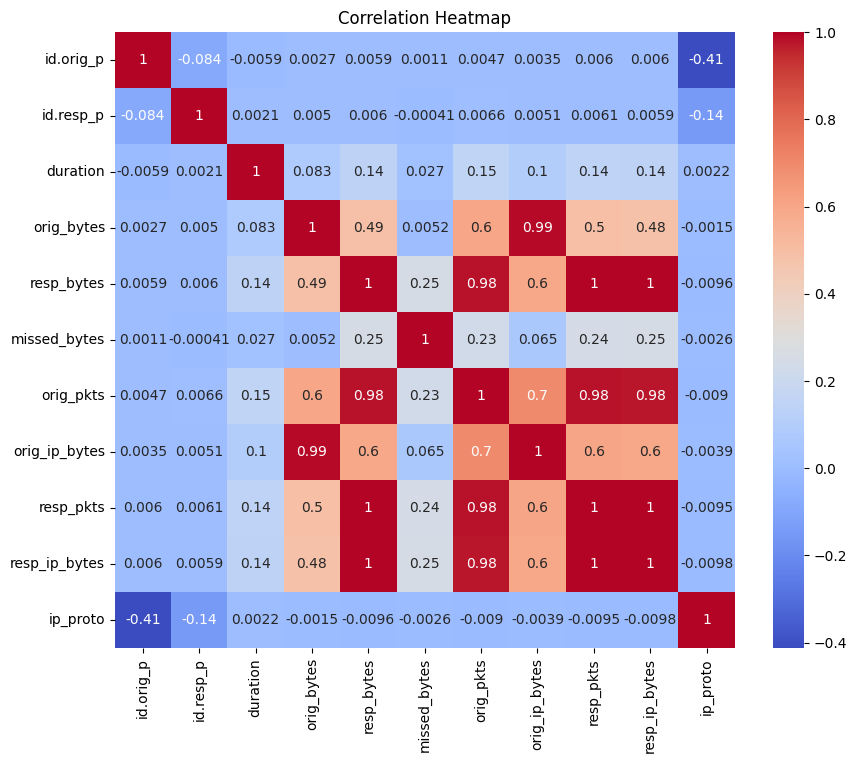

In [56]:
# Seaborn heatmap
data_plot = features.drop(columns=['proto', 'service', 'conn_state', 'local_orig', 'local_resp', 'tunnel_parents', 'id.orig_h', 'id.resp_h'])
plt.figure(figsize=(10, 8))
sns.heatmap(data_plot.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

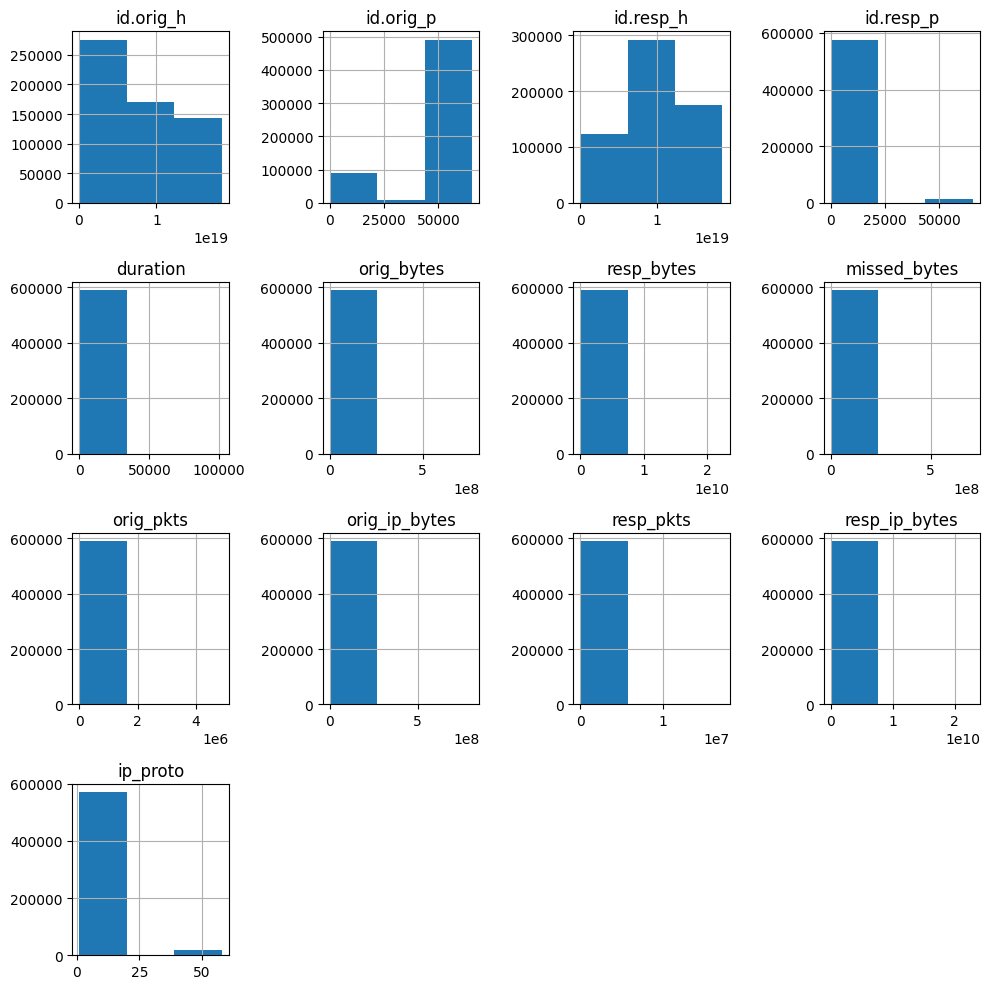

In [57]:
# Histograms Plots
features.hist(figsize=(10, 10), bins=3)
plt.tight_layout()
plt.show()

In [58]:
# Odd distribution
# Makese sense given how dynamic network data can be
features.describe()



,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,ip_proto
count,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000
mean,7496677078251632640.000000,48833.762263,8869667705424014336.000000,1832.736604,26.161225,11775.076614,685678.503998,2767.162850,123.262965,17880.019349,528.919421,710038.018767,15.698806
std,6529898172347401216.000000,19577.178664,4953610702242279424.000000,7850.605292,452.508149,1808793.449669,48071619.374610,1184424.138822,9927.766480,2038868.266110,36569.368093,49340229.085111,8.822587
min,76741595213951792.000000,0.000000,112941588812549.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,380062881728321536.000000,50651.000000,6764359067301277696.000000,53.000000,0.017960,33.000000,58.000000,0.000000,1.000000,81.000000,1.000000,102.000000,17.000000
50%,7808242618821495808.000000,55425.000000,6764359067301277696.000000,53.000000,0.025476,45.000000,113.000000,0.000000,1.000000,95.000000,1.000000,158.000000,17.000000
75%,11674056241634650112.000000,60513.000000,14128986099517732864.000000,443.000000,0.978497,1166.000000,732.000000,0.000000,10.000000,1938.000000,6.000000,1232.750000,17.000000
max,18395119167068968960.000000,65535.000000,18445700098465122304.000000,65388.000000,101771.212935,766267257.000000,22462762124.000000,710859519.000000,4885329.000000,808713302.000000,17158749.000000,22943207096.000000,58.000000


In [59]:

zeek_data_encoded = pd.get_dummies(features, columns=['proto', 'service', 'conn_state', 'local_orig', 'local_resp', 'tunnel_parents' ], drop_first=True, dtype=float)
zeek_data_encoded.info()
zeek_data_encoded

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589530 entries, 0 to 589529
Data columns (total 55 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id.orig_h                        589530 non-null  uint64 
 1   id.orig_p                        589530 non-null  int64  
 2   id.resp_h                        589530 non-null  uint64 
 3   id.resp_p                        589530 non-null  int64  
 4   duration                         589530 non-null  float64
 5   orig_bytes                       589530 non-null  int64  
 6   resp_bytes                       589530 non-null  int64  
 7   missed_bytes                     589530 non-null  int64  
 8   orig_pkts                        589530 non-null  int64  
 9   orig_ip_bytes                    589530 non-null  int64  
 10  resp_pkts                        589530 non-null  int64  
 11  resp_ip_bytes                    589530 non-null  int64  
 12  ip

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,...,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR,local_orig_T,local_resp_T
0,380062881728321521,65430,1364297740679492638,443,0.176656,0,228408,0,34,1876,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,380062881728321521,65289,12827931226928160802,443,0.089289,24,65,0,6,300,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
2,380062881728321521,65430,1364297740679492638,443,0.213978,1544,156813,0,29,3088,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
3,11591817193114903545,52768,6764359067301278027,53,0.019330,33,83,0,1,81,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
4,11591817193114903545,55558,6764359067301278027,53,0.017523,33,61,0,1,81,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589525,8391317418713992830,1,8505081591278050737,0,156.840116,8290,0,0,97,12946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
589526,14717460543277579385,135,1278210090157757166,136,838.535921,840,560,0,35,2520,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
589527,14717460543277579385,136,1278210090157757166,135,871.438452,576,384,0,36,2304,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
589528,2947864998378284997,3,380062881728321521,1,892.440025,122608,0,0,1703,170292,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


## Data Analysis
- Data visualization
- Distribution analysis
- Correlation analysis

Unique src IPs 357
Total Conenctions 589530


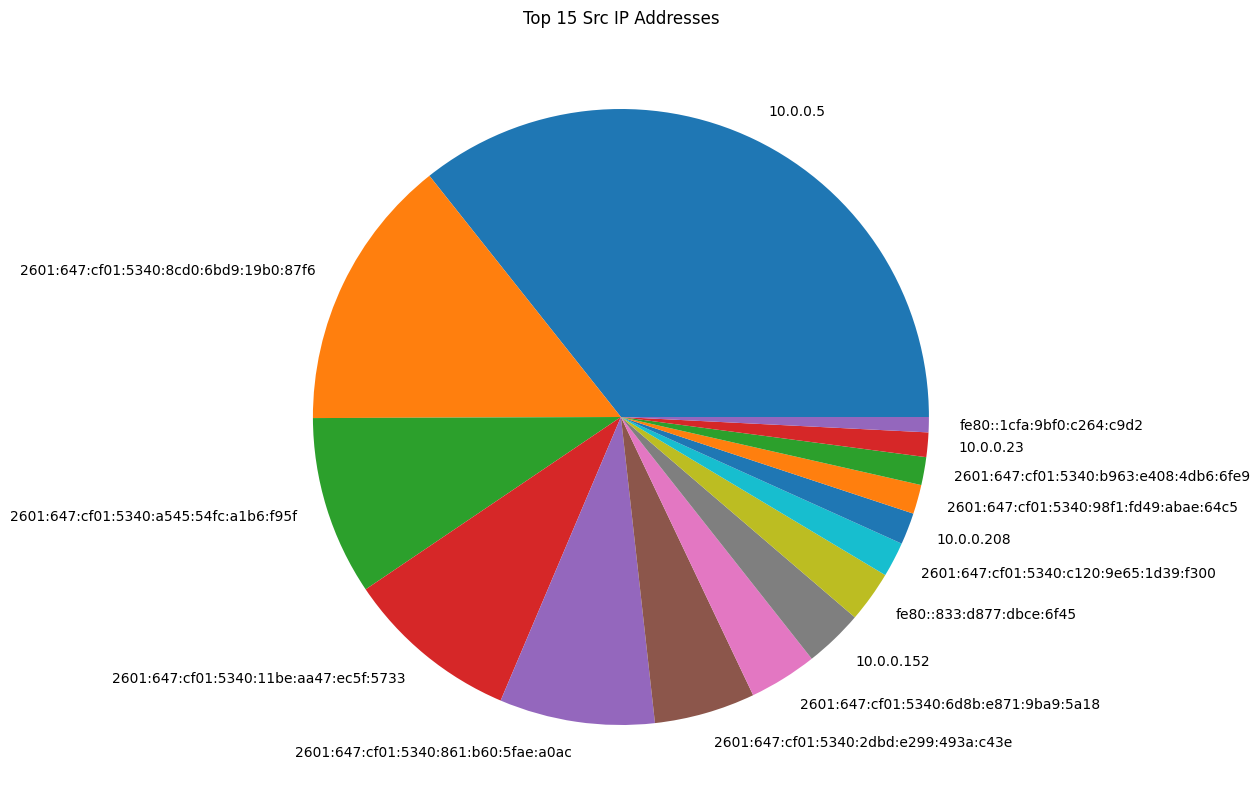

In [60]:
# Lets learn more about my network data!
# Lets Plot

ip_counts = zeek_data['id.orig_h'].value_counts()[:15]
labels = ip_counts.index
values = ip_counts.values

fig, ax = plt.subplots()
ax.set_title('Top 15 Src IP Addresses')
fig.set_size_inches(10, 10)
ax.pie(values, labels=labels);

print('Unique src IPs', len(zeek_data['id.orig_h'].value_counts()))
print(f'Total Conenctions', len((zeek_data)))

Unique dst IPs 6682
Total Conenctions 589530


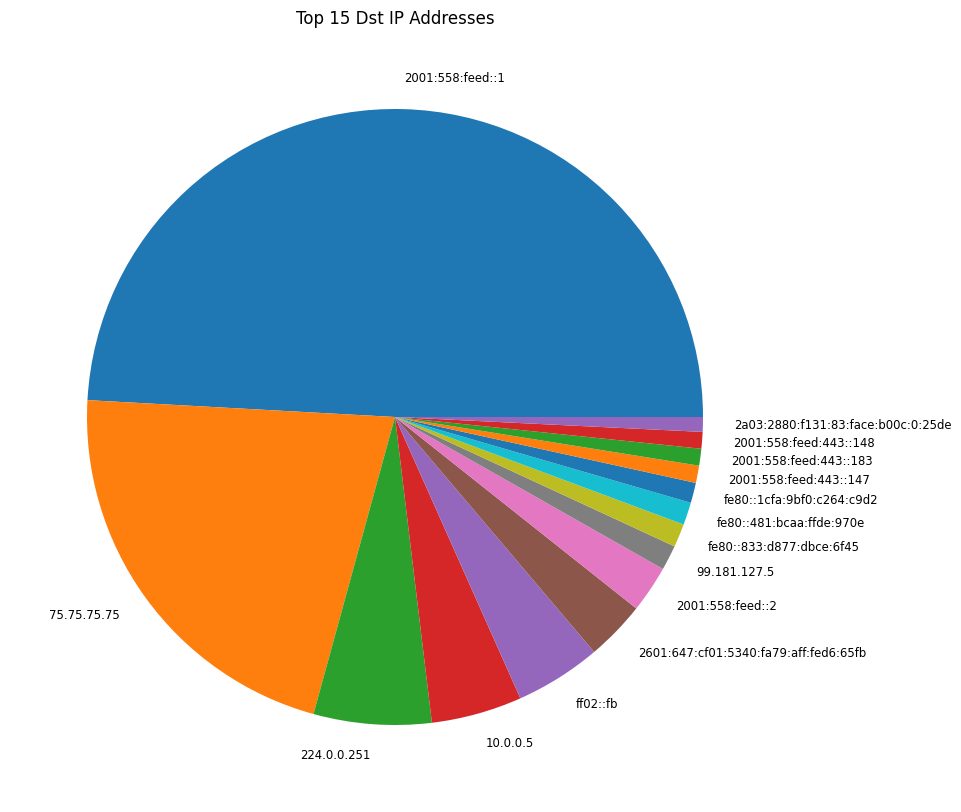

In [61]:

ip_counts1 = zeek_data['id.resp_h'].value_counts()[:15]
labels1 = ip_counts1.index
values1 = ip_counts1.values
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.set_title('Top 15 Dst IP Addresses')
ax.pie(values1, labels=labels1,textprops={'size': 'smaller'});
print('Unique dst IPs', len(zeek_data['id.resp_h'].value_counts()))
print(f'Total Conenctions', len((zeek_data)))

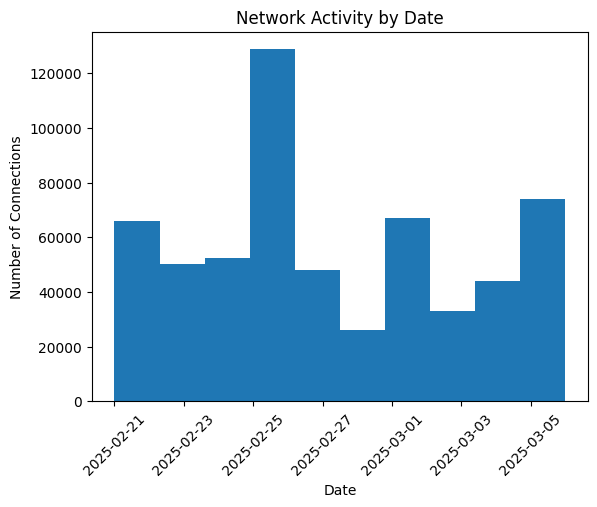

In [62]:
plt.hist(zeek_data['ts'].dt.date, bins=10)  # Add bins for better visualization
plt.xlabel('Date')
plt.ylabel('Number of Connections')
plt.title('Network Activity by Date')
plt.xticks(rotation=45)
plt.show()


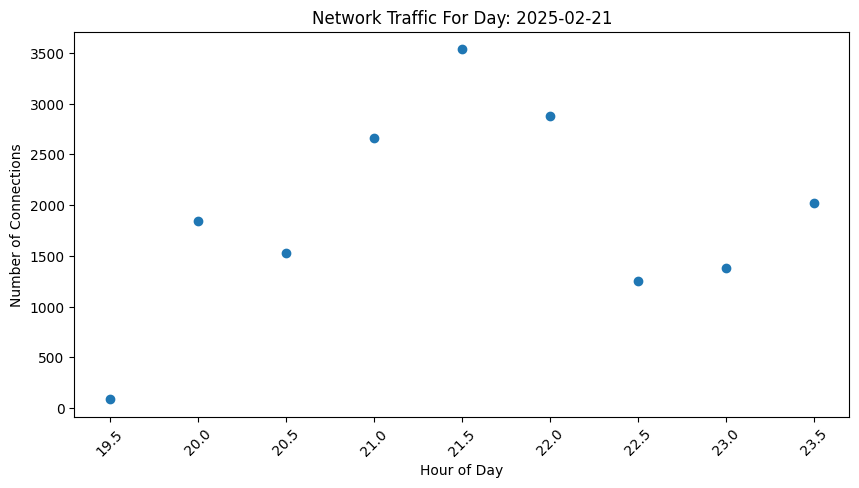

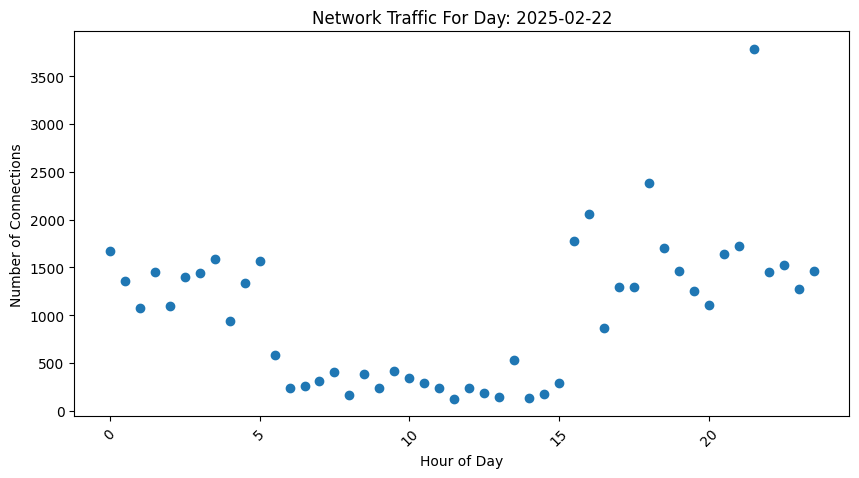

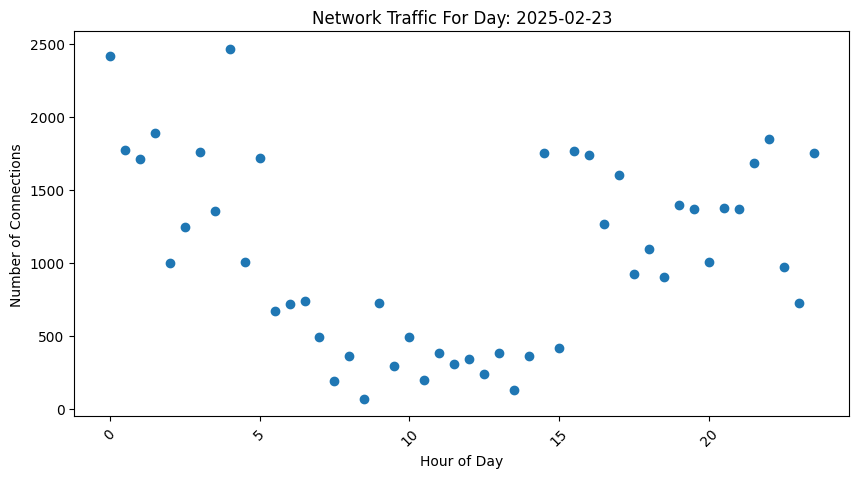

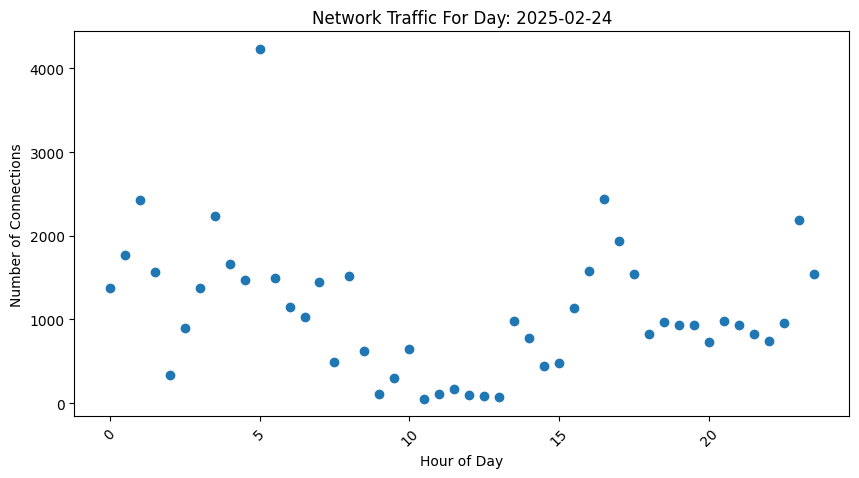

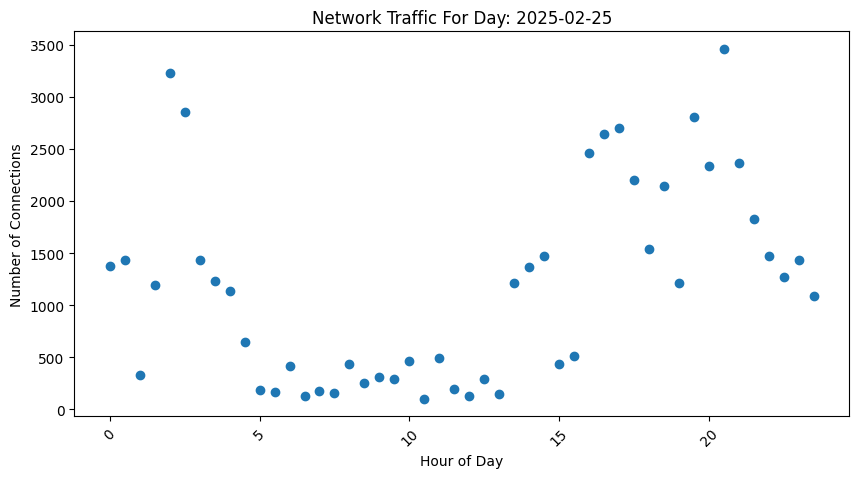

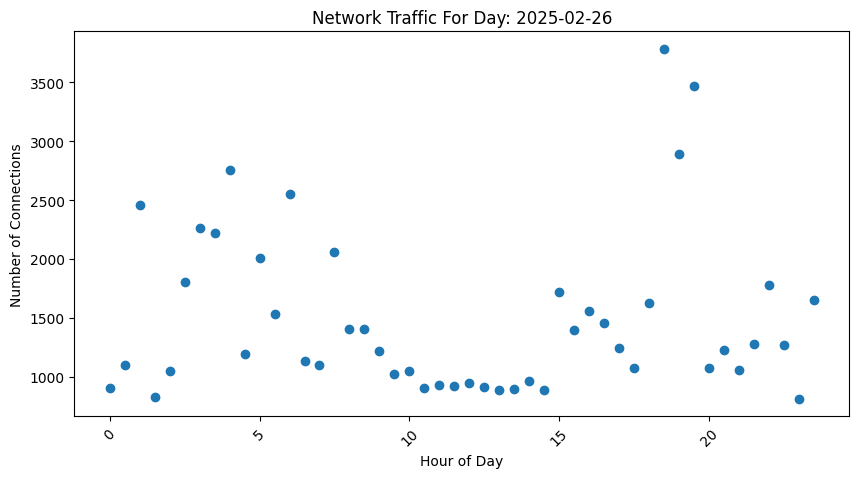

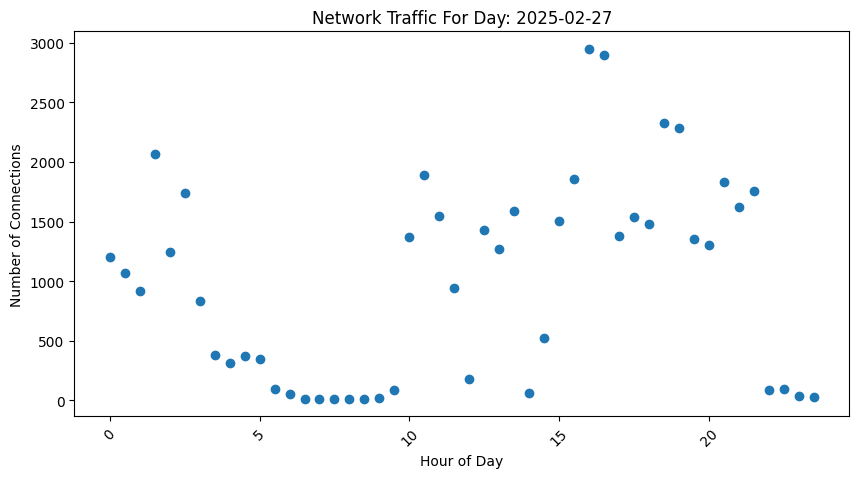

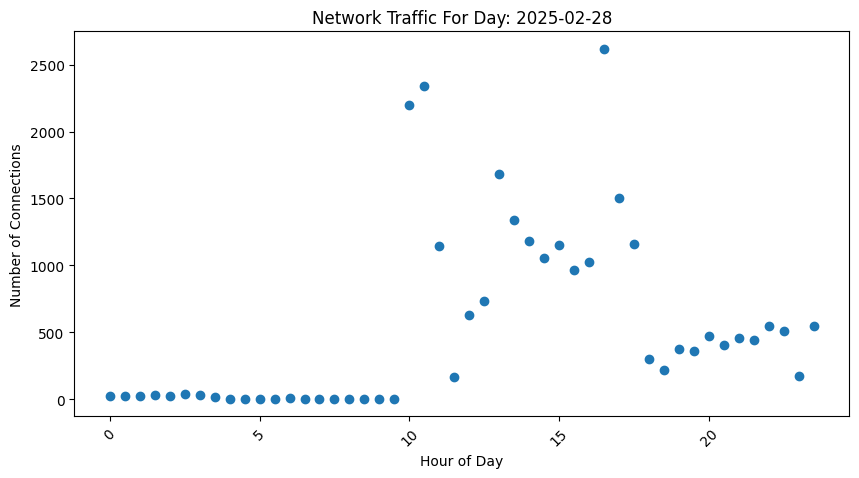

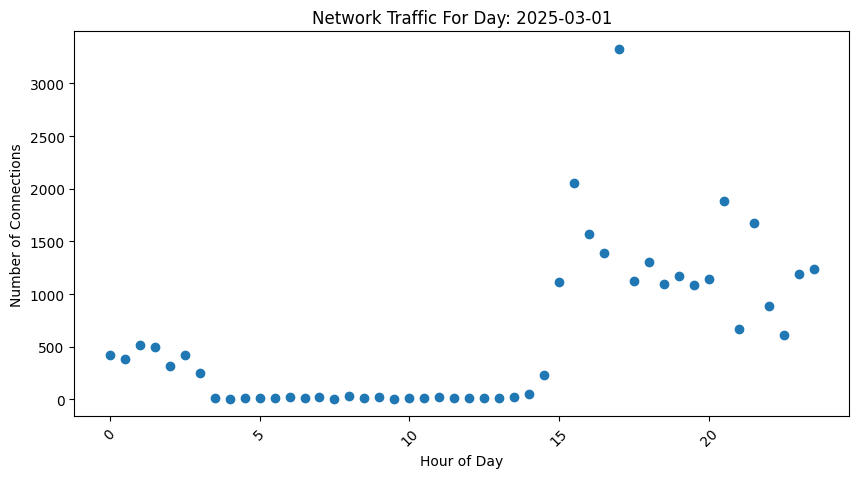

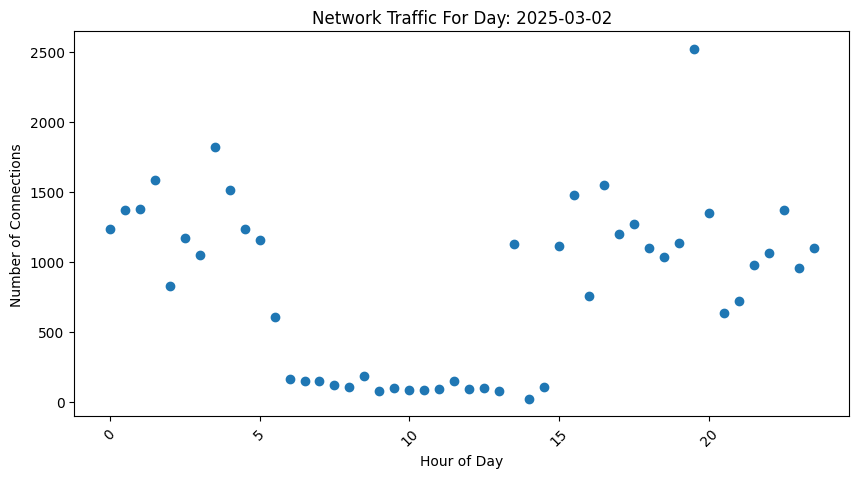

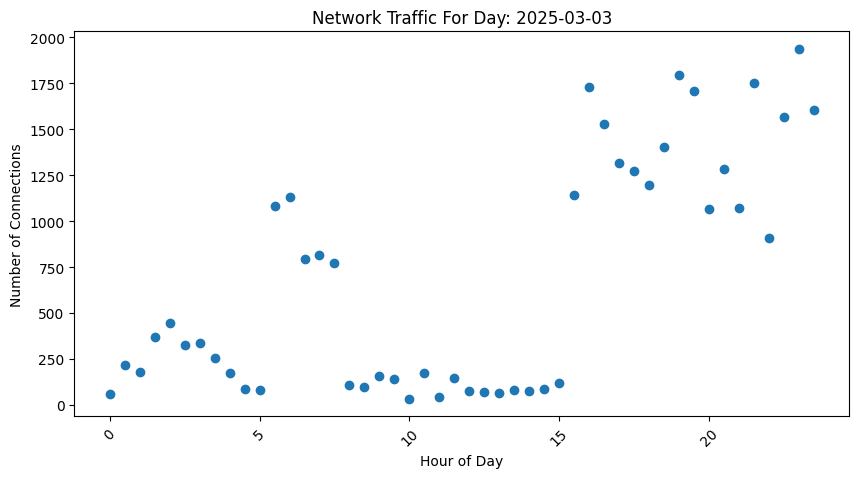

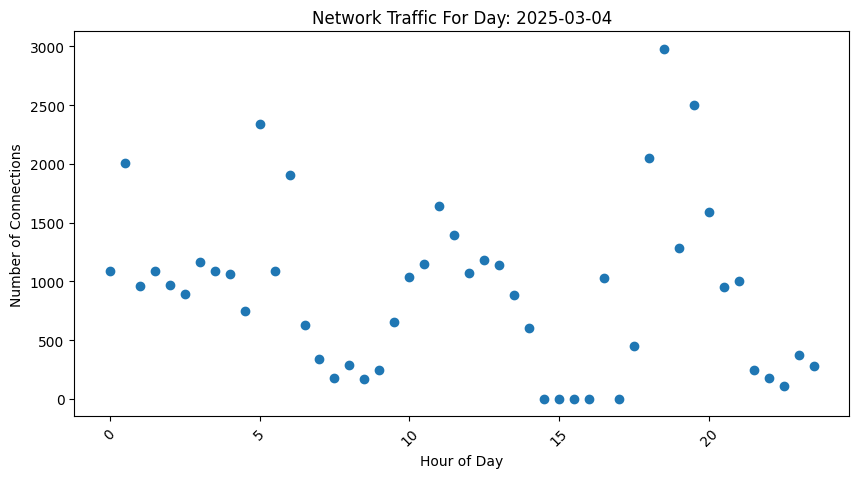

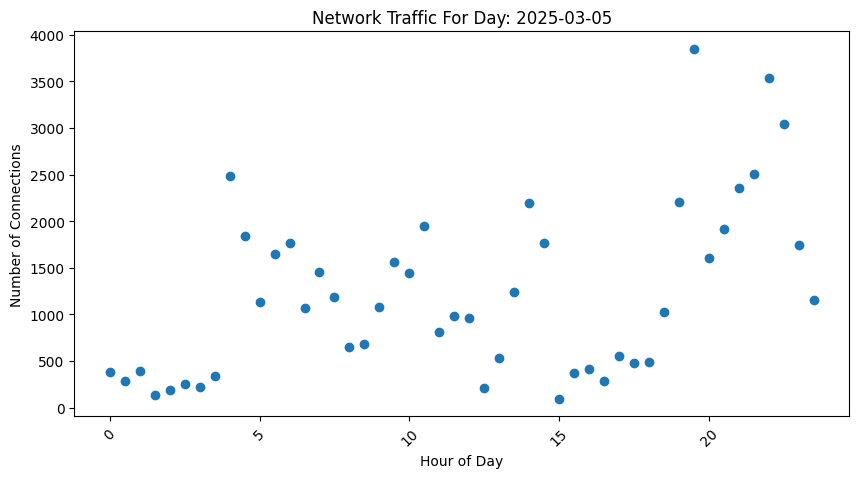

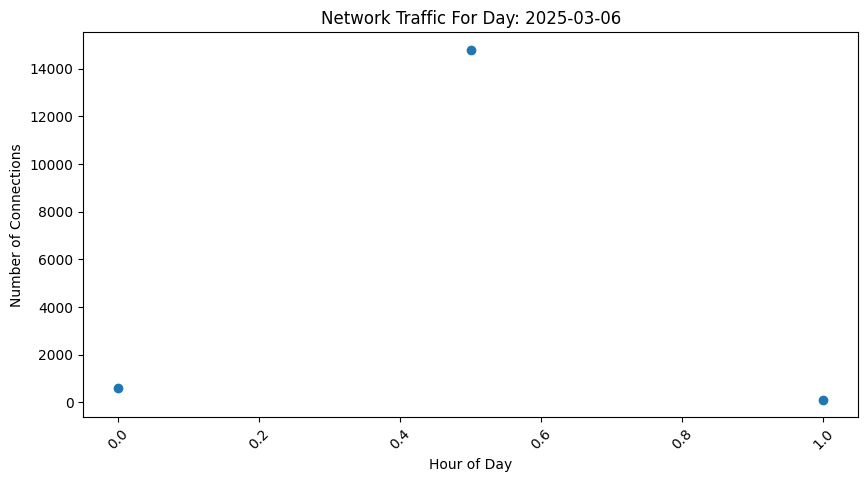

In [63]:
# By Day
mapping = {} # Timestamp to Size Mapping
count = 0
for group,value in zeek_data.groupby(pd.Grouper(key='ts', freq='D')):
  for groups,values in value.groupby(pd.Grouper(key='ts', freq='30min')):
      mapping[groups] = len(values)
df = pd.DataFrame(list(mapping.items()), columns=['Timestamp', 'Size'])
df
# Find how many unique days
# zeek_data['ts'].dt.date.nunique() = 14
length_ts = zeek_data['ts'].dt.date.nunique()

# See what dates are actually in each group
df['date'] = df['Timestamp'].dt.date
for date, day_data in df.groupby('date'):
    plt.figure(figsize=(10, 5))
    plt.title(f"Network Traffic For Day: {date}")
    plt.scatter(day_data['Timestamp'].dt.hour + day_data['Timestamp'].dt.minute/60, day_data['Size'])
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Connections')
    plt.xticks(rotation=45)
    plt.show()

proto
udp                  437883
tcp                  127802
icmp                  20476
unknown_transport      3369
Name: count, dtype: int64


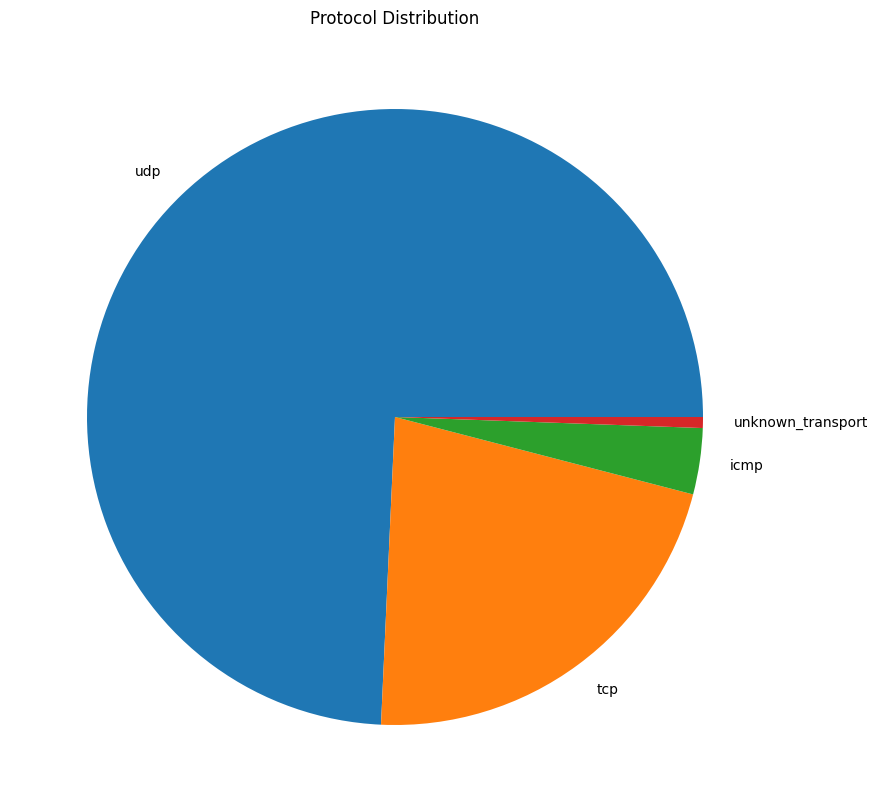

In [64]:
# Protocol Analysis
ip_counts2 = zeek_data['proto'].value_counts()[:20]
labels2 = ip_counts2.index
values2 = ip_counts2.values
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.set_title('Protocol Distribution')
ax.pie(values2, labels=labels2);
print(ip_counts2)

## Conclusion (Analysis)
- The src is mainly our local machine ip which is expected
  - What is surprising is the number of unique src ip's are 357 out of 587000 packets sent and recieved
  - This is very surprising and really speaks volumes about my internet activity, where im mainly being served content froma select number of ip's.
  - The fact I use WireGuard vpn could also influence these results
- The dst is interesting where a large bulk of the traffic is to comcat dns which is just recursive resolver
  - A lot of it being multicast is very interesting too! And how much network bandwidth its taking up is impressive.
  - Most of all this shows that I'm mostly querying the dns, for a majority of the traffic
- Protocol Analysis
  - Mainly shows udp which lines up with the use of wire gaurd and constant dns queries.

- Overall very insightful results of layer 4 network traffic, with the usage of udp taking over tcp by a landslide.

## Fit Model
- Scaled Data
- Split data
- Trained on an autoencoded nueral net
- Used a bottleneck archtecture
- Threshold is around 98

In [65]:
# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(zeek_data_encoded)

original_indices = zeek_data_encoded.index.tolist()
X_train, X_test, train_indices, test_indices = train_test_split( features_scaled, original_indices, test_size=0.2, random_state=42 )

# Build the Sequential Autoencoder Model
learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.001
)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'), # Bottle neck layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(X_train.shape[1], activation='linear')
])
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), callbacks=[early_stopping] )

reconstructions = model.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

threshold = np.percentile(mse, 98)

anomalies = mse > threshold
print(f"Anomalies detected: {np.sum(anomalies)}")

anomalous_test_indices = np.where(anomalies)[0]
anomalous_original_indices = [test_indices[i] for i in anomalous_test_indices]
anomalous_traffic = zeek_data_encoded.loc[anomalous_original_indices]
print(anomalous_traffic)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
14739/14739 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.6910 - val_loss: 0.4998
Epoch 2/50
14739/14739 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.5766 - val_loss: 0.4459
Epoch 3/50
14739/14739 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 0.4611 - val_loss: 0.4107
Epoch 4/50
14739/14739 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.5065 - val_loss: 0.4099
Epoch 5/50
14739/14739 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.4596 - val_loss: 0.3803
Epoch 6/50
14739/14739 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.3902 - val_loss: 0.3781
Epoch 7/50
14739/14739 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.4350 - val_loss: 0.3685
Epoch 8/50
14739/14739 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.4778 - val_loss: 0.3858
Epoch 9/50
14739/14739 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.4557 - val_loss: 0.3744
Epoch 10/50
14739/14739 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.4704 - val_loss: 0.3758
Epoch 11/50
14739/14739 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.4265 - val_loss: 0.38

In [66]:
from google.colab import drive
drive.mount('/content/drive')

# Save with new format
model.save('/content/drive/MyDrive/network_anomaly_modelv5.keras')

# Save other components (these stay the same)
import joblib
joblib.dump(scaler, '/content/drive/MyDrive/scalerv5.pkl')
joblib.dump(threshold, '/content/drive/MyDrive/thresholdv5.pkl')

print("✅ Model saved in native Keras format!")


Mounted at /content/drive
✅ Model saved in native Keras format!
